In [ ]:
import numpy as np
import os
import pandas as pd
from typing import Dict, Tuple
import time
import odor_stat_calculations as osc
from plume_sim import Cosmos
from plume_sim_fast import CosmosFast
import matplotlib.pyplot as plt 
from cfd_rigolli import Cfd_rigolli
from cfd_rigolli import Cfd_rigolli_BDCATS
import multiprocessing as mp


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
class SurgeCastAgent:
    def __init__(self, tau=0.42, noise=1.9, bias=0.25, threshold=4.5,
                 hit_trigger='peak', surge_amp=2.0, tau_surge=0.5,
                 cast_freq=1.0, cast_width=0.8, bounds=None):
        self.tau = tau
        self.noise = noise
        self.bias = bias
        self.threshold = threshold
        self.hit_trigger = hit_trigger
        self.surge_amp = surge_amp
        self.tau_surge = tau_surge
        self.cast_freq = cast_freq
        self.cast_width = cast_width
        self.bounds = bounds
        self.surge_amp_ = surge_amp / (tau_surge * np.exp(-1))

    def reflect_if_out_of_bounds(self, v: np.ndarray, x: np.ndarray):
        if self.bounds is None:
            return v, x
        v_new = v.copy()
        x_new = x.copy()
        for dim in range(2):
            if x[dim] < self.bounds[dim][0]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][0] - x[dim]
            elif x[dim] > self.bounds[dim][1]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][1] - x[dim]
        return v_new, x_new

def tracking(predictor, bounds, start_pos, target_pos, surge_agent, 
          target_weight, plume_timeout, closest_to_source, duration):
    dt = 0.005
    n_steps = int(duration / dt)

    # Original arrays
    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps,2))
    vs = np.zeros((n_steps,2))
    xs = np.zeros((n_steps,2))
    hits = np.zeros(n_steps)
    
    # New arrays for additional metrics
    velocities = np.zeros((n_steps,2))  # Velocity vector
    speeds = np.zeros(n_steps)          # Speed magnitude
    accelerations = np.zeros(n_steps)   # Acceleration magnitude
    angles = np.zeros(n_steps)          # Heading angle
    angular_velocities = np.zeros(n_steps)  # Rate of turning
    crosswind_distances = np.zeros(n_steps) # Distance perpendicular to wind
    upwind_distances = np.zeros(n_steps)    # Distance parallel to wind
    dist_to_targets = np.zeros(n_steps)     # Distance to target
    time_since_last_hits = np.zeros(n_steps) # Time since last whiff
    casting_phases = np.zeros(n_steps)      # Phase of casting motion
    local_curvatures = np.zeros(n_steps)    # Path curvature

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -np.inf
    last_odor = 0
    hit_occurred = False
    prev_angle = 0

    # Initial bias calculation remains same
    to_target = target_pos - x
    to_target /= (np.linalg.norm(to_target) + 1e-6)
    upwind = np.array([-1.0, 0.0])
    b = (1 - target_weight)*upwind + target_weight*to_target
    b *= (surge_agent.bias / np.linalg.norm(b))

    for t_ctr in range(n_steps):
        current_odor = predictor.step_update(x[0], x[1], dt)
        odors[t_ctr] = current_odor

        # Original hit detection logic
        if surge_agent.hit_trigger == 'peak':
            if current_odor >= surge_agent.threshold:
                if current_odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr*dt
                    remaining_steps = n_steps - t_ctr
                    ts_ = ts[:remaining_steps] - ts[0]
                    surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
                    surges[t_ctr:] = np.minimum(surge_force, 50.0)
                last_odor = current_odor
            else:
                last_odor = 0
                hit_occurred = False

        if t_ctr > 0:
            # Original movement logic
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = (t_ctr*dt - last_hit_time)
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break
                
            to_target /= (dist_to_target + 1e-6)

            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(0.8, 
                    target_weight + 0.1*(time_since_hit - plume_timeout)/plume_timeout)

            if surges[t_ctr] > 1.0:
                surge_direction = np.array([-1.0, -0.05*x[1]])
                surge_direction /= np.linalg.norm(surge_direction)
                b = (1 - current_target_weight)*surge_direction + current_target_weight*to_target
                b *= surges[t_ctr]
            else:
                cast_freq = 0.5
                cast_phase = np.sin(2*np.pi*cast_freq*ts[t_ctr])
                base_cast_width = 1.0
                dist_factor = min(1.0, dist_to_target/20.0)
                cast_width = base_cast_width*dist_factor

                crosswind = np.array([0.0, cast_phase*cast_width])
                upwind = np.array([-0.2, 0.0])
                b = (1 - current_target_weight)*(upwind + crosswind) + current_target_weight*to_target
                norm_b = np.linalg.norm(b)
                if norm_b > 0:
                    b *= surge_agent.bias/norm_b

            # Update velocity and position
            v += (dt/surge_agent.tau)*(-v + eta + b)
            x += v*dt
            v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Calculate additional metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 0:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr-1])/dt
            
            # Heading angle and angular velocity
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            if t_ctr > 0:
                angle_diff = np.arctan2(np.sin(current_angle - prev_angle),
                                      np.cos(current_angle - prev_angle))
                angular_velocities[t_ctr] = angle_diff/dt
            prev_angle = current_angle
            
            # Distance components
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target
            time_since_last_hits[t_ctr] = time_since_hit
            casting_phases[t_ctr] = cast_phase
            
            # Path curvature (for segments of 3 points)
            if t_ctr >= 2:
                pos_window = xs[t_ctr-2:t_ctr+1]
                dx = np.gradient(pos_window[:,0])
                dy = np.gradient(pos_window[:,1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                curvature = np.abs(dx*ddy - dy*ddx) / (dx**2 + dy**2)**1.5
                local_curvatures[t_ctr] = np.mean(curvature)

        # Store original metrics
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim if ended early
    if t_ctr < (n_steps-1):
        trim_slice = slice(0, t_ctr+1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        odors = odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]

    # Create complete DataFrame
    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:,0],
        'y': xs[:,1],
        'vx': velocities[:,0],
        'vy': velocities[:,1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'odor': odors,
        'whiff': hits,
        'surge_force': surges,
        'bias_force_x': bs[:,0],
        'bias_force_y': bs[:,1]
    })
    

    if trajectory_df.iloc[-1]['x'] == 0 and trajectory_df.iloc[-1]['y'] == 0:
            trajectory_df = trajectory_df.iloc[:-1]
    # xs[t_ctr] = target_pos

    # fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    
    # # Plot trajectory
    # axs[0].plot(trajectory_df.x, trajectory_df.y, c='blue', label='Path')
    # axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    # axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    
    # # Plot whiffs
    # whiff_rows = trajectory_df[trajectory_df.whiff == 1]
    # if not whiff_rows.empty:
    #     axs[0].plot(whiff_rows.x, whiff_rows.y, 'g*', label='Whiffs')
    
    # axs[0].set_title(f'Trajectory (Whiffs: {trajectory_df.whiff.sum()})')
    # axs[0].legend()
    
    # # Plot odor concentration
    # axs[1].plot(trajectory_df.time, trajectory_df.odor, 'b-', label='Odor')
    # if not whiff_rows.empty:
    #     axs[1].plot(whiff_rows.time, whiff_rows.odor, 'r*', label='Detected Whiffs')
    
    # axs[1].axhline(surge_agent.threshold, color='r', linestyle='--', label='Threshold')
    # axs[1].legend()
    # axs[1].set_title('Odor concentration')
    
    # # Plot control forces
    # # Calculate bias force magnitude from x and y components
    # bias_force = np.sqrt(trajectory_df.bias_force_x**2 + trajectory_df.bias_force_y**2)
    # axs[2].plot(trajectory_df.time, bias_force, 'g-', label='Bias Force')
    # axs[2].plot(trajectory_df.time, trajectory_df.surge_force, 'r-', label='Surge Force')
    # axs[2].legend()
    # axs[2].set_title('Control Forces')
    
    # fig.suptitle('my odor simulator')
    # fig.tight_layout()
    
    return trajectory_df



In [ ]:
if __name__ == "__main__":
    # Setup simulation parameters
    bounds = [(5, 40), (0, 8)]
    # start_pos = np.array([20.0, 6.0])
    target_pos = np.array([5.0, 4.0])
    
    surge_agent = SurgeCastAgent(
        tau=0.3,
        noise=3.0,
        bias=0.1,
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=1.5,
        tau_surge=1.0,
        bounds=bounds
    )
    
    target_weight = 0
    plume_timeout = 10.0
    closest_to_source = 0.2
    sim_duration = 100.0
    
    dirname = '../data/simulator/rigolli/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

    # Create predictor (no df_test needed for real-time)
    predictor = CosmosFast(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )

    # Define the bounds for random starting points
    x_bounds = (7, 30)
    y_bounds = (3, 5)
    
    # Number of random starting points
    num_starting_points = 50
    
    # Generate random integer starting points within bounds
    np.random.seed(42)  # For reproducibility
    random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
    random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)
    
    # Lists to store results
    wall_times = []
    cpu_times = []
    cpu_hours_list = []
    starting_positions = []
    
    # Record starting wall-clock time and CPU times for the entire run
    start_wall_total = time.time()
    start_cpu_total = os.times()
    
    # Loop over all random starting points
    for i in range(num_starting_points):
        start_pos = np.array([float(random_x[i]), float(random_y[i])])
        print(start_pos)
        starting_positions.append(start_pos.copy())
        
        print(f"\nRunning simulation {i+1}/50 from position {start_pos}:")
        
        # Record starting wall-clock time and CPU times for this iteration
        start_wall = time.time()
        start_cpu = os.times()
        
        # Run the tracking simulation
        osdf = tracking(predictor, bounds, start_pos, target_pos, surge_agent,
                        target_weight, plume_timeout, closest_to_source, sim_duration)
        
        # Record ending times
        end_wall = time.time()
        end_cpu = os.times()
        
        # Calculate elapsed wall-clock time
        wall_time_elapsed = end_wall - start_wall
        
        # Calculate total CPU time including child processes
        cpu_time_used = ((end_cpu.user - start_cpu.user) +
                        (end_cpu.system - start_cpu.system) +
                        (end_cpu.children_user - start_cpu.children_user) +
                        (end_cpu.children_system - start_cpu.children_system))
        
        # Convert CPU time from seconds to hours
        cpu_hours_val = cpu_time_used / 3600
        
        # Append results to lists
        wall_times.append(wall_time_elapsed)
        cpu_times.append(cpu_time_used)
        cpu_hours_list.append(cpu_hours_val)
        
        print('Starting position: ({}, {})'.format(random_x[i], random_y[i]))
        print('Wall-clock time: {:.2f} seconds'.format(wall_time_elapsed))
        print('Total CPU time: {:.2f} seconds'.format(cpu_time_used))
        print('Total CPU hours: {:.4f} hours'.format(cpu_hours_val))
    
    # Record ending times for the entire run
    end_wall_total = time.time()
    end_cpu_total = os.times()
    
    # Calculate total elapsed times
    total_wall_time = end_wall_total - start_wall_total
    total_cpu_time = ((end_cpu_total.user - start_cpu_total.user) +
                      (end_cpu_total.system - start_cpu_total.system) +
                      (end_cpu_total.children_user - start_cpu_total.children_user) +
                      (end_cpu_total.children_system - start_cpu_total.children_system))
    total_cpu_hours = total_cpu_time / 3600
    
    print("\nOverall Performance:")
    print('Total wall-clock time: {:.2f} seconds'.format(total_wall_time))
    print('Total CPU time: {:.2f} seconds'.format(total_cpu_time))
    print('Total CPU hours: {:.4f} hours'.format(total_cpu_hours))
    
    # Create a DataFrame with all the results
    time_df = pd.DataFrame({
        'start_x': random_x,
        'start_y': random_y,
        'wall_time_s': wall_times,
        'cpu_time_s': cpu_times,
        'cpu_hours': cpu_hours_list
    })
    
   
    
    # Save the results
    # time_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/random_starts_time.h5', mode='w', key='time_df')
    # Uncomment the line above to save the results

    # start=time.time()
    # for i in range(1):
    #     osdf=pd.DataFrame()
    #     osdf= tracking(predictor, bounds, start_pos,target_pos,surge_agent, target_weight, plume_timeout, closest_to_source, sim_duration )
        # osdf.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/os'+str(i+1)+'.h5', mode='w',key='osdf')
    # time_taken_osdf = time.time()-start
    # print('time_taken_osdf:', time_taken_osdf)

# time_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cosmos_time.h5', mode='w',key='time_df')

[13.  4.]

Running simulation 1/50 from position [13.  4.]:
Target reached at [5.07180265 3.8154021 ]
Starting position: (13, 4)
Wall-clock time: 3.55 seconds
Total CPU time: 3.55 seconds
Total CPU hours: 0.0010 hours
[26.  3.]

Running simulation 2/50 from position [26.  3.]:
Starting position: (26, 3)
Wall-clock time: 4.09 seconds
Total CPU time: 4.09 seconds
Total CPU hours: 0.0011 hours
[21.  4.]

Running simulation 3/50 from position [21.  4.]:
Starting position: (21, 4)
Wall-clock time: 4.24 seconds
Total CPU time: 4.23 seconds
Total CPU hours: 0.0012 hours
[17.  5.]

Running simulation 4/50 from position [17.  5.]:
Starting position: (17, 5)
Wall-clock time: 3.99 seconds
Total CPU time: 4.01 seconds
Total CPU hours: 0.0011 hours
[14.  5.]

Running simulation 5/50 from position [14.  5.]:
Target reached at [5.19891135 4.01570155]
Starting position: (14, 5)
Wall-clock time: 0.88 seconds
Total CPU time: 0.87 seconds
Total CPU hours: 0.0002 hours
[27.  3.]

Running simulation 6/50 f

In [78]:
# osdf.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/os8.h5', mode='w',key='osdf')
# test=pd.read_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/os8.h5')

### Rigolli Tracker

In [79]:
class CfdOdorPredictor:
    def __init__(self, cfd_simulator, scale_data_fn):
        self.cfd = cfd_simulator
        self.scale_data = scale_data_fn
        self.config = type('Config', (), {
            'warmup_steps': 0,
            'rows_per_second': 200
        })()

    def get_wind_at_position(self, pos: Tuple[float, float], time: float) -> Tuple[float, float, float]:
        return self.cfd.get_wind_at_position_and_time(pos, time)

    def get_odor_at_position(self, pos: Tuple[float, float], time: float) -> float:
        odor = self.cfd.get_odor_at_position_and_time(pos, time)
        return odor


def scale_data(data):
    min_val = 0
    max_val = 16
    return (((data - min_val) / (max_val - min_val)) * 10)

def cfd_tracking(
    cfd_predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    target_weight,
    plume_timeout,
    closest_to_source,
    duration
):
    dt = 0.005
    n_steps = int(duration / dt)

    # Time and basic arrays
    ts = np.arange(n_steps)*dt
    scaled_odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps,2))
    vs = np.zeros((n_steps,2))
    xs = np.zeros((n_steps,2))
    hits = np.zeros(n_steps)

    # Additional metric arrays
    velocities = np.zeros((n_steps,2))  # Velocity vector
    speeds = np.zeros(n_steps)          # Speed magnitude
    accelerations = np.zeros(n_steps)   # Acceleration magnitude
    angles = np.zeros(n_steps)          # Heading angle
    angular_velocities = np.zeros(n_steps)  # Rate of turning
    crosswind_distances = np.zeros(n_steps) # Distance perpendicular to wind
    upwind_distances = np.zeros(n_steps)    # Distance parallel to wind
    dist_to_targets = np.zeros(n_steps)     # Distance to target
    time_since_last_hits = np.zeros(n_steps) # Time since last whiff
    casting_phases = np.zeros(n_steps)      # Phase of casting motion
    local_curvatures = np.zeros(n_steps)    # Path curvature

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -np.inf
    last_odor = 0
    hit_occurred = False
    prev_angle = 0

    # Initial bias
    to_target = target_pos - x
    to_target /= (np.linalg.norm(to_target) + 1e-6)
    upwind = np.array([-1.0, 0.0])
    b = (1 - target_weight)*upwind + target_weight*to_target
    b *= (surge_agent.bias / np.linalg.norm(b))

    for t_ctr in range(n_steps):
        # Get odor
        raw_odor = cfd_predictor.get_odor_at_position(tuple(x), ts[t_ctr])
        current_odor = cfd_predictor.scale_data(raw_odor)
        scaled_odors[t_ctr] = current_odor

        # Whiff detection
        if surge_agent.hit_trigger == 'peak':
            if current_odor >= surge_agent.threshold:
                if current_odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr*dt
                    remaining_steps = n_steps - t_ctr
                    ts_ = ts[:remaining_steps] - ts[0]
                    surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
                    surges[t_ctr:] = np.minimum(surge_force, 50.0)
                last_odor = current_odor
            else:
                last_odor = 0
                hit_occurred = False

        if t_ctr > 0:
            # Movement logic
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = (t_ctr*dt - last_hit_time)

            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break
            to_target /= (dist_to_target + 1e-6)

            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(
                    0.8, 
                    target_weight + 0.1*(time_since_hit - plume_timeout)/plume_timeout
                )

            # Movement mode (surge or cast)
            if surges[t_ctr] > 1.0:
                surge_direction = np.array([-1.0, -0.05*x[1]])
                surge_direction /= np.linalg.norm(surge_direction)
                b = (1 - current_target_weight)*surge_direction + current_target_weight*to_target
                b *= surges[t_ctr]
            else:
                cast_freq = 0.5
                cast_phase = np.sin(2*np.pi*cast_freq*ts[t_ctr])
                base_cast_width = 1.0
                dist_factor = min(1.0, dist_to_target/20.0)
                cast_width = base_cast_width*dist_factor

                crosswind = np.array([0.0, cast_phase*cast_width])
                upwind = np.array([-0.2, 0.0])
                b = (1 - current_target_weight)*(upwind + crosswind) + current_target_weight*to_target
                norm_b = np.linalg.norm(b)
                if norm_b > 0:
                    b *= surge_agent.bias/norm_b

            # Update position and velocity
            v += (dt/surge_agent.tau)*(-v + eta + b)
            x += v*dt
            v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Calculate metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 0:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr-1])/dt
            
            # Heading angle and angular velocity
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            if t_ctr > 0:
                angle_diff = np.arctan2(np.sin(current_angle - prev_angle),
                                      np.cos(current_angle - prev_angle))
                angular_velocities[t_ctr] = angle_diff/dt
            prev_angle = current_angle
            
            # Distance metrics
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target
            time_since_last_hits[t_ctr] = time_since_hit
            casting_phases[t_ctr] = cast_phase
            
            # Path curvature
            if t_ctr >= 2:
                pos_window = xs[t_ctr-2:t_ctr+1]
                dx = np.gradient(pos_window[:,0])
                dy = np.gradient(pos_window[:,1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                curvature = np.abs(dx*ddy - dy*ddx) / (dx**2 + dy**2)**1.5
                local_curvatures[t_ctr] = np.mean(curvature)

        # Store basic metrics
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim arrays if ended early
    if t_ctr < (n_steps-1):
        trim_slice = slice(0, t_ctr+1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        scaled_odors = scaled_odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]

    # Create DataFrame with all metrics
    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:,0],
        'y': xs[:,1],
        'vx': velocities[:,0],
        'vy': velocities[:,1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'odor': scaled_odors,
        'whiff': hits,
        'surge_force': surges,
        'bias_force_x': bs[:,0],
        'bias_force_y': bs[:,1]
    })
    # xs[t_ctr] = target_pos
    if trajectory_df.iloc[-1]['x'] == 0 and trajectory_df.iloc[-1]['y'] == 0:
        trajectory_df = trajectory_df.iloc[:-1]

    # fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    
    # # Plot trajectory
    # axs[0].plot(cfd_df.x, cfd_df.y, label='Path')
    # axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    # axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')

    # # Plot whiffs
    # whiff_rows = cfd_df[cfd_df.whiff == 1]
    # if not whiff_rows.empty:
    #     axs[0].plot(whiff_rows.x, whiff_rows.y, 'g*', label='Whiffs')

    # axs[0].set_title(f'Trajectory (Whiffs: {cfd_df.whiff.sum()})')
    # axs[0].legend()

    # # Plot odor concentration
    # axs[1].plot(cfd_df.time, cfd_df.odor, 'b-', label='Odor')
    # if not whiff_rows.empty:
    #     axs[1].plot(whiff_rows.time, whiff_rows.odor, 'r*', label='Detected Whiffs')

    # axs[1].axhline(surge_agent.threshold color='r', linestyle='--', label='Threshold')
    # axs[1].legend()
    # axs[1].set_title('Odor concentration')

    # # Plot control forces
    # # Calculate bias force magnitude from x and y components
    # bias_force = np.sqrt(cfd_df.bias_force_x**2 + cfd_df.bias_force_y**2)
    # axs[2].plot(cfd_df.time, bias_force, 'g-', label='Bias Force')
    # axs[2].plot(cfd_df.time, cfd_df.surge_force, 'r-', label='Surge Force')
    # axs[2].legend()
    # axs[2].set_title('Control Forces')

    # fig.suptitle('CFD simulator')
    # fig.tight_layout()
    
    return trajectory_df



In [90]:
# cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
# cfd_predictor = CfdOdorPredictor(cfd, scale_data)
bounds = [(5, 40), (0, 8)]
# start_pos = np.array([20.0, 6.0])

target_pos = np.array([5.0, 4.0])

# Create surge-cast agent
surge_agent = SurgeCastAgent(
    tau=0.3,
    noise=3.0,
    bias=0.1,
    threshold=6.5,
    hit_trigger='peak',
    surge_amp=1.5,
    tau_surge=1.0,
    bounds=bounds
)

target_weight = 0
plume_timeout = 10.0
closest_to_source = 0.2
sim_duration = 100.0

# Define the bounds for random starting points
x_bounds = (7, 30)
y_bounds = (3, 5)

# Number of random starting points
num_starting_points = 50

# Generate random integer starting points within bounds
np.random.seed(42)  # For reproducibility
random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)

# Lists to store results
wall_times = []
cpu_times = []
cpu_hours_list = []
starting_positions = []

# Record starting wall-clock time and CPU times for the entire run
start_wall_total = time.time()
start_cpu_total = os.times()

# Loop over all random starting points
for i in range(num_starting_points):
    start_pos = np.array([float(random_x[i]), float(random_y[i])])
    starting_positions.append(start_pos.copy())
    
    print(f"\nRunning simulation {i+1}/50 from position {start_pos}:")
    new_cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
    cfd_predictor = CfdOdorPredictor(new_cfd, scale_data)
    
    # Record starting wall-clock time and CPU times for this iteration
    start_wall = time.time()
    start_cpu = os.times()
    
    # Run the CFD tracking simulation
    cfd_df = cfd_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent,
                          target_weight, plume_timeout, closest_to_source, sim_duration)
    
    # Record ending times
    end_wall = time.time()
    end_cpu = os.times()
    
    # Calculate elapsed wall-clock time
    wall_time_elapsed = end_wall - start_wall
    
    # Calculate total CPU time including child processes
    cpu_time_used = ((end_cpu.user - start_cpu.user) +
                     (end_cpu.system - start_cpu.system) +
                     (end_cpu.children_user - start_cpu.children_user) +
                     (end_cpu.children_system - start_cpu.children_system))
    
    # Convert CPU time from seconds to hours
    cpu_hours_val = cpu_time_used / 3600
    
    # Append results to lists
    wall_times.append(wall_time_elapsed)
    cpu_times.append(cpu_time_used)
    cpu_hours_list.append(cpu_hours_val)
    
    print('Starting position: ({}, {})'.format(random_x[i], random_y[i]))
    print('Wall-clock time: {:.2f} seconds'.format(wall_time_elapsed))
    print('Total CPU time: {:.2f} seconds'.format(cpu_time_used))
    print('Total CPU hours: {:.4f} hours'.format(cpu_hours_val))

# Record ending times for the entire run
end_wall_total = time.time()
end_cpu_total = os.times()

# Calculate total elapsed times
total_wall_time = end_wall_total - start_wall_total
total_cpu_time = ((end_cpu_total.user - start_cpu_total.user) +
                  (end_cpu_total.system - start_cpu_total.system) +
                  (end_cpu_total.children_user - start_cpu_total.children_user) +
                  (end_cpu_total.children_system - start_cpu_total.children_system))
total_cpu_hours = total_cpu_time / 3600

print("\nOverall Performance:")
print('Total wall-clock time: {:.2f} seconds'.format(total_wall_time))
print('Total CPU time: {:.2f} seconds'.format(total_cpu_time))
print('Total CPU hours: {:.4f} hours'.format(total_cpu_hours))

# Create a DataFrame with all the results
cfd_time = pd.DataFrame({
    'start_x': random_x,
    'start_y': random_y,
    'wall_time_s': wall_times,
    'cpu_time_s': cpu_times,
    'cpu_hours': cpu_hours_list
})

# start=time.time()
# for i in range(1):
#     # cfd_df=pd.DataFrame()
#     cfd_df = cfd_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent, 
#                           target_weight, plume_timeout, closest_to_source, sim_duration)
#     # cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/feb28/cfd'+str(i+1)+'.h5', mode='w',key='osdf')

# time_taken_cfd = time.time()-start
# print('time_taken_cfd:', time_taken_cfd)
cfd_time.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cfd_bstrap_time.h5', mode='w',key='cfd_time')



Running simulation 1/50 from position [13.  4.]:
Starting position: (13, 4)
Wall-clock time: 108.23 seconds
Total CPU time: 148.70 seconds
Total CPU hours: 0.0413 hours

Running simulation 2/50 from position [26.  3.]:
Starting position: (26, 3)
Wall-clock time: 110.71 seconds
Total CPU time: 151.44 seconds
Total CPU hours: 0.0421 hours

Running simulation 3/50 from position [21.  4.]:
Target reached at [5.11683859 4.16122918]
Starting position: (21, 4)
Wall-clock time: 45.93 seconds
Total CPU time: 63.09 seconds
Total CPU hours: 0.0175 hours

Running simulation 4/50 from position [17.  5.]:
Target reached at [5.17697242 3.90688889]
Starting position: (17, 5)
Wall-clock time: 64.13 seconds
Total CPU time: 88.03 seconds
Total CPU hours: 0.0245 hours

Running simulation 5/50 from position [14.  5.]:
Target reached at [5.14650273 4.13518286]
Starting position: (14, 5)
Wall-clock time: 29.48 seconds
Total CPU time: 40.17 seconds
Total CPU hours: 0.0112 hours

Running simulation 6/50 from 

In [93]:
cfd_time

,start_x,start_y,wall_time_s,cpu_time_s,cpu_hours
0,13,4,108.234797,148.70,0.041306
1,26,3,110.710474,151.44,0.042067
2,21,4,45.933259,63.09,0.017525
3,17,5,64.125235,88.03,0.024453
4,14,5,29.482404,40.17,0.011158
5,27,3,89.148294,123.54,0.034317
6,13,5,109.950360,151.79,0.042164
7,25,5,104.327187,143.24,0.039789
8,29,4,110.128911,151.10,0.041972
9,17,3,96.554842,133.91,0.037197


In [92]:
cot_df=pd.read_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cosmos_bstrap_time.h5')
cft_df=pd.read_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cfd_bstrap_time.h5')

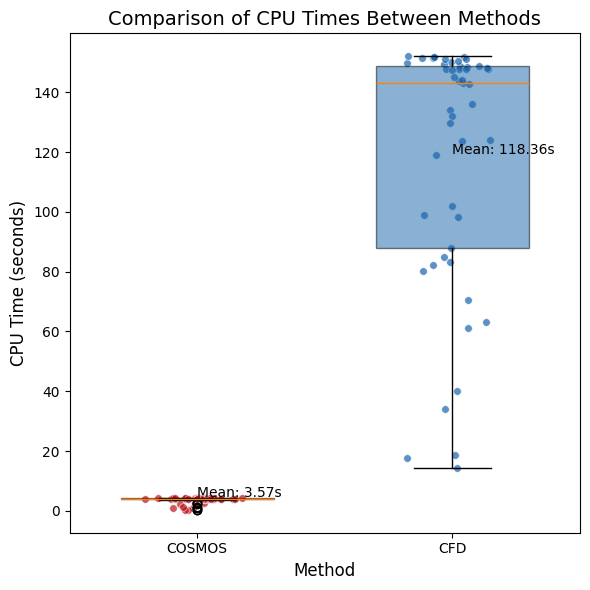

In [ ]:

stat_model_times = cot_df['cpu_time_s'].values[:-1]
cfd_model_times = cft_df['cpu_time_s'].values[:-1]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxplot = ax.boxplot(
    [stat_model_times, cfd_model_times], 
    labels=['COSMOS', 'CFD'],
    patch_artist=True,
    widths=0.6
)

# Customize the boxplot colors
colors = ['#bc141a', '#1764ab']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add title and labels
ax.set_title('Comparison of CPU Times Between Methods', fontsize=14)
ax.set_ylabel('CPU Time (seconds)', fontsize=12)
ax.set_xlabel('Method', fontsize=12)

ax.grid(False)
mean_stat = np.mean(stat_model_times)
mean_cfd = np.mean(cfd_model_times)
ax.text(1, mean_stat, f'Mean: {mean_stat:.2f}s', verticalalignment='bottom', fontsize=10)
ax.text(2, mean_cfd, f'Mean: {mean_cfd:.2f}s', verticalalignment='bottom', fontsize=10)

fig.tight_layout()


In [257]:
# cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cfd8.h5', mode='w',key='cfd_df')

In [70]:
cfd_old = Cfd_rigolli(dirname="../data/rigolli/")
cfd_new = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
df=pd.read_hdf('/home/gorilla/An/data/simulator/rigolli/rigolli_jan22.h5')

In [71]:
s=100000
e=105000
# plt.scatter(df.distance_along_streakline[s:e], df.nearest_from_streakline[s:e])

In [41]:
start=time.time()
odor_old = []
for i in range(len(df[s:e])):
    odor_old.append(cfd_old.get_odor_at_position_and_time((df.distance_along_streakline[i],df.nearest_from_streakline[i]),20))
time_taken_old = time.time()-start
print('time_taken_old:', time_taken_old)

time_taken_old: 57.50307512283325


BDCATS

In [72]:
start=time.time()
odor_new = []
for i in range(len(df[s:e])):
    odor_new.append(cfd_new.get_odor_at_position_and_time((df.distance_along_streakline[i],df.nearest_from_streakline[i]),20))
time_taken_new = time.time()-start
print('time_taken_new:', time_taken_new)

time_taken_new: 0.5815508365631104


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

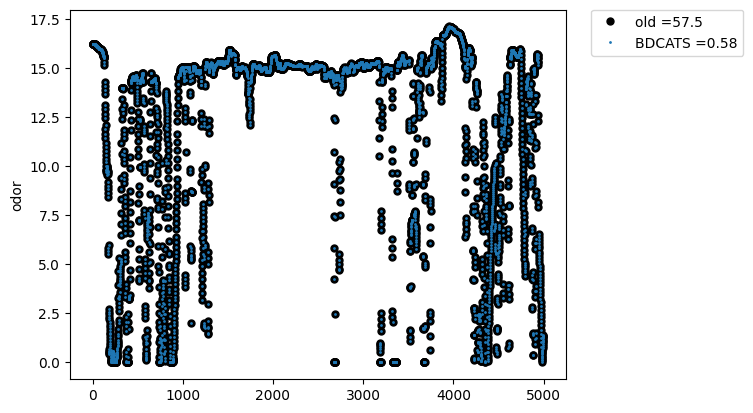

In [73]:
plt.plot(odor_old, 'o', markersize=5, label='old =' + str(round(time_taken_old, 2)), c='black')
plt.plot(odor_new, 'o', markersize=1, label='BDCATS =' + str(round(time_taken_new, 2)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('odor')
plt.plot

=== Performance Comparison ===
Original method: 57.74s, Peak memory: 6355.10 MB
BD-CATS method: 0.74s, Peak memory: 6370.88 MB
Speedup: 78.30x
Memory efficiency: 1.00x


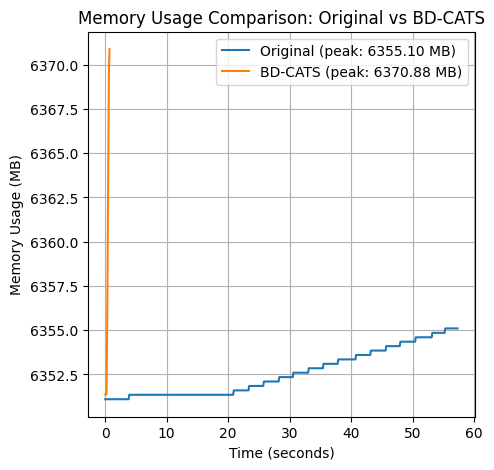


=== Memory Usage Breakdown ===
Top 10 types using memory before BD-CATS initialization:
dict                       199121
function                   158463
list                       118238
tuple                      113125
cell                       50482
ReferenceType              40220
memoryview                 39216
Parameter                  37783
builtin_function_or_method 30005
Name                       23332

Top 10 types after BD-CATS usage:
dict                       198144
function                   158209
list                       117642
tuple                      112800
cell                       50472
ReferenceType              39987
memoryview                 39216
Parameter                  37783
builtin_function_or_method 29770
Name                       23332

Object growth during BD-CATS usage:
tuple             112791       +51
dict              198145       +51
FontProperties      2328       +44
ReferenceType      39987       +11
list              117640       

In [ ]:

from memory_profiler import profile, memory_usage
import matplotlib.pyplot as plt

def compare_memory_usage(original_cfd, bdcats_cfd, df, s, e, time_value):
    """
    Compare memory usage between original CFD implementation and BD-CATS version.
    """
    # Create list of test positions from dataframe
    test_positions = [(df.distance_along_streakline[i], df.nearest_from_streakline[i]) for i in range(s, e)]
    
    # Define functions to profile
    def original_method():
        results = []
        for pos in test_positions:
            results.append(original_cfd.get_odor_at_position_and_time(pos, time_value))
        return results
    
    def bdcats_method():
        results = []
        for pos in test_positions:
            results.append(bdcats_cfd.get_odor_at_position_and_time(pos, time_value))
        return results
    
    # Track time for original method
    start_time = time.time()
    original_mem = memory_usage((original_method, [], {}), interval=0.1)
    original_time = time.time() - start_time
    
    # Track time for BD-CATS method
    start_time = time.time()
    bdcats_mem = memory_usage((bdcats_method, [], {}), interval=0.1)
    bdcats_time = time.time() - start_time
    
    # Calculate metrics
    results = {
        'original': {
            'time': original_time,
            'memory_profile': original_mem,
            'peak_memory': max(original_mem),
            'avg_memory': sum(original_mem) / len(original_mem)
        },
        'bdcats': {
            'time': bdcats_time,
            'memory_profile': bdcats_mem,
            'peak_memory': max(bdcats_mem),
            'avg_memory': sum(bdcats_mem) / len(bdcats_mem)
        },
        'comparison': {
            'time_speedup': original_time / bdcats_time,
            'memory_ratio': max(original_mem) / max(bdcats_mem)
        }
    }
    
    return results

# Create instances of both classes
original_cfd = Cfd_rigolli(dirname="../data/rigolli/")
bdcats_cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")

df=pd.read_hdf('/home/gorilla/An/data/simulator/rigolli/rigolli_jan22.h5')

# Run the comparison using your dataframe data
results = compare_memory_usage(original_cfd, bdcats_cfd, df, s, e, time_value=20)

# Print summary
print(f"=== Performance Comparison ===")
print(f"Original method: {results['original']['time']:.2f}s, Peak memory: {results['original']['peak_memory']:.2f} MB")
print(f"BD-CATS method: {results['bdcats']['time']:.2f}s, Peak memory: {results['bdcats']['peak_memory']:.2f} MB")
print(f"Speedup: {results['comparison']['time_speedup']:.2f}x")
print(f"Memory efficiency: {results['comparison']['memory_ratio']:.2f}x")

# Plot memory usage over time
plt.figure(figsize=(5, 5))
time_points_original = np.arange(0, len(results['original']['memory_profile']) * 0.1, 0.1)
time_points_bdcats = np.arange(0, len(results['bdcats']['memory_profile']) * 0.1, 0.1)

plt.plot(time_points_original, results['original']['memory_profile'], 
         label=f"Original (peak: {results['original']['peak_memory']:.2f} MB)")
plt.plot(time_points_bdcats, results['bdcats']['memory_profile'], 
         label=f"BD-CATS (peak: {results['bdcats']['peak_memory']:.2f} MB)")

plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison: Original vs BD-CATS')
plt.legend()
plt.show()

# For a detailed investigation of where memory is being used
print("\n=== Memory Usage Breakdown ===")
try:
    import objgraph
    print("Top 10 types using memory before BD-CATS initialization:")
    objgraph.show_most_common_types(limit=10)
    
    # Force some garbage collection
    import gc
    gc.collect()
    
    # Run a short test with the BD-CATS method
    bdcats_test_results = bdcats_cfd.get_odor_at_position_and_time((20, 5), 20)
    
    print("\nTop 10 types after BD-CATS usage:")
    objgraph.show_most_common_types(limit=10)
    
    print("\nObject growth during BD-CATS usage:")
    objgraph.show_growth()
except ImportError:
    print("objgraph not installed. Run 'pip install objgraph' for detailed object tracking.")